# Supervised/Unsupervised Corner Cases
In 11.compound_ranking_comparison, we found that there is a correlation between the supervised (Rephetio) and unsupervised(sum of negative log p-values) rankings, but there are points that are highly ranked in Rephetio that have low ranks in hetmech, and vice versa. This notebook will attempt to uncover whether those compounds have divergent results due to noise or a signal we haven't seen before.

In [1]:
import configparser
import math

import pandas
from plotnine import *
import psycopg2

from neo4j.v1 import GraphDatabase
import hetio.readwrite
import hetio.neo4j

/home/benheil/miniconda3/envs/hetmech/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: The 'neo4j.v1' package is deprecated, import from 'neo4j' instead


In [2]:
parser = configparser.ConfigParser()
parser.read('../database.ini')

db_password = parser['psql']['password']
epilepsy_id = 'DOID:1826'

supervised_predictions_df = pandas.read_csv('https://raw.githubusercontent.com/dhimmel/learn/b2460a1ecdec1078d673634688784f3eb5e3fc43/prediction/predictions/probabilities.tsv', sep='\t')

In [3]:
def construct_disease_query(disease_id):
    # If this query is used for different node types, it may be necessary to add an additional condition
    # that the matching node is of the correct type e.g. Disease
    query = f'''
            SELECT path_count, p_value, metapath_id, source_node.name AS source_name, 
                   target_node.name AS target_name, source_node.identifier AS source_identifier 
            FROM dj_hetmech_app_pathcount pc 
            JOIN dj_hetmech_app_node source_node 
               ON pc.source_id = source_node.id 
            JOIN dj_hetmech_app_node target_node 
               ON pc.target_id = target_node.id     
            WHERE target_node.identifier='{disease_id}' OR source_node.identifier='{disease_id}'
            ORDER BY pc.p_value
            '''
    return query

In [4]:
def get_disease_df(disease_id, db_password, supervised_predictions_df):
    query = construct_disease_query(disease_id)
    connection = psycopg2.connect(host = 'hetmech-db-dev.cobepk65dd7j.us-east-1.rds.amazonaws.com', 
                                  database = 'dj_hetmech', user = 'read_only_user', password = db_password)

    # Get the unsupervised compound information for a given disease
    metapaths = pandas.read_sql(query, connection)

    # If the source node is a disease instead of a compound, swap it with the target node
    reversed_indices = metapaths['source_identifier'] == disease_id
    metapaths['temp'] = metapaths['source_name']
    metapaths.loc[reversed_indices, 'source_name'] = metapaths['target_name']
    metapaths.loc[reversed_indices, 'target_name'] = metapaths['temp']

    metapaths = metapaths.drop(['temp', 'source_identifier'], axis=1)
    
    metapaths = metapaths.sort_values(by=['source_name', 'metapath_id'])
    # Ensure that you only have one copy of each (source_name, metapath_id) pair
    metapaths = metapaths.drop_duplicates(subset=['source_name', 'metapath_id'])
    # Remove any rows with NaN values
    metapaths = metapaths.dropna()
    min_p_value = metapaths[metapaths.p_value != 0].p_value.min()
    # Replace zero p-values to keep the log conversion from breaking
    metapaths.loc[metapaths.p_value == 0, 'p_value'] = min_p_value
    metapaths['neg_log_p_value'] = metapaths.p_value.apply(lambda x: -math.log10(x))

    max_column = metapaths.groupby('source_name')['neg_log_p_value'].max()
    mean_column = metapaths.groupby('source_name')['neg_log_p_value'].mean()

    neg_log_sum = metapaths.groupby('source_name').sum()
    neg_log_sum = neg_log_sum.sort_values(by='neg_log_p_value', ascending=False)

    neg_log_sum['max_neg_log'] = max_column
    neg_log_sum['mean_neg_log'] = mean_column
    neg_log_sum['max_percent_of_total'] = 100 * (neg_log_sum['max_neg_log'] / neg_log_sum['neg_log_p_value'])

    disease_predictions_df = supervised_predictions_df[supervised_predictions_df.disease_id == disease_id]
    # Remove predictions on drugs not in the other dataframe
    disease_predictions_df = disease_predictions_df[disease_predictions_df.compound_name.isin(neg_log_sum.index)]
    disease_predictions_df = disease_predictions_df.sort_values(by='disease_percentile', ascending=False)

    # Get the unsupervised compound ranking
    neg_log_sum = neg_log_sum.reset_index()
    neg_log_sum['unsupervised_rank'] = neg_log_sum.index

    # Sort neg_log_sum matching names in disease_predicitons_df 
    combined_df = neg_log_sum.merge(disease_predictions_df, how="left", right_on='compound_name', left_on='source_name')

    combined_df = combined_df.sort_values(by='disease_percentile', ascending=False).reset_index(drop=True)
    combined_df['supervised_rank'] = combined_df.index.copy()

    return metapaths, combined_df

In [5]:
metapath_df, sum_df = get_disease_df(epilepsy_id, db_password, supervised_predictions_df)
columns_to_drop = ['path_count',
                   'p_value',
                   'max_neg_log',
                   'mean_neg_log',
                   'max_percent_of_total',
                   'n_trials',
                   'status_trials',
                   'status_drugcentral',
                   'training_prediction',
                   'category',
                   'compound_name',
                   'disease_percentile',
                   'compound_percentile',
                   'prior_prob',
                   'prediction',
                   'disease_name'
                  ]
sum_df = sum_df.drop(columns_to_drop, axis=1)
sum_df.rename(columns = {'neg_log_p_value': 'compound_sum_neg_log_p_value'}, inplace=True)

sum_df['divergence'] = sum_df['supervised_rank'] - sum_df['unsupervised_rank']

sum_df.head()

,source_name,compound_sum_neg_log_p_value,unsupervised_rank,compound_id,disease_id,status,supervised_rank,divergence
0,Topiramate,43.735595,0,DB00273,DOID:1826,1,0,0
1,Ethotoin,34.047045,12,DB00754,DOID:1826,0,1,-11
2,Quazepam,24.477587,65,DB01589,DOID:1826,0,2,-63
3,Alprazolam,33.511351,15,DB00404,DOID:1826,0,3,-12
4,Primidone,33.931793,13,DB00794,DOID:1826,1,4,-9


In [6]:
combined_df = metapath_df.merge(sum_df)
combined_df = combined_df.sort_values(by='divergence')

## Evaluation
We'll calculate the sum of the p_values for the metapaths in the top 500 entries and bottom 500 entries in the dataframe. This acts as a metric for counting which metapaths were important in compounds that ranked highly in Rephetio but not Hetmech, and vice versa.

In [7]:
high_supervised_rank_df = combined_df.head(500).groupby('metapath_id').sum()
high_supervised_rank_df = high_supervised_rank_df[['neg_log_p_value']]
high_supervised_rank_df.rename(columns={'neg_log_p_value': 'sum_neg_log_p_value'}, inplace=True)
high_supervised_rank_df = high_supervised_rank_df.sort_values(by='sum_neg_log_p_value', ascending=False)
high_supervised_rank_df = high_supervised_rank_df.reset_index()
high_supervised_rank_df = high_supervised_rank_df.head(10)

high_supervised_rank_df.head()

,metapath_id,sum_neg_log_p_value
0,CcSEcCtD,266.477444
1,CbGbCtD,96.622064
2,CrCbGaD,79.634679
3,CrCrCtD,57.709511
4,CbGaD,54.217686


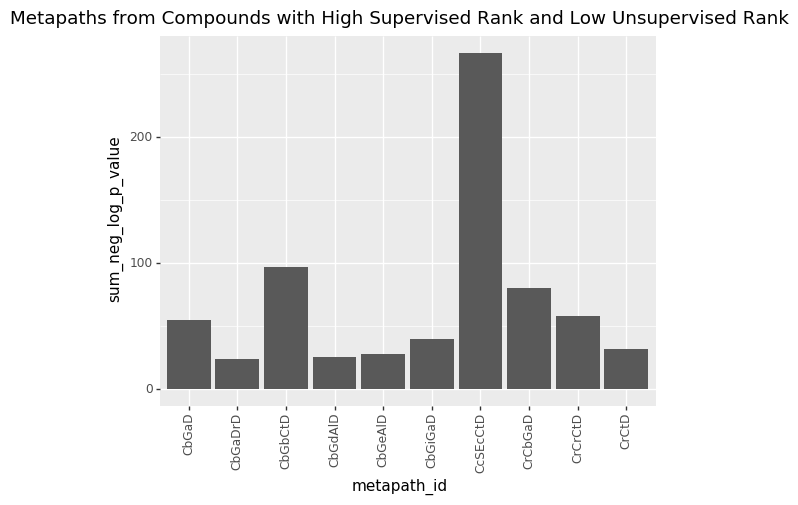

<ggplot: (-9223363260327831499)>

In [8]:
(ggplot(high_supervised_rank_df, aes('metapath_id', 'sum_neg_log_p_value')) 
       + geom_bar(stat='identity') 
       + theme(axis_text_x = element_text(angle = 90, hjust = .5))
       + ggtitle('Metapaths from Compounds with High Supervised Rank and Low Unsupervised Rank') 
)

In [9]:
low_supervised_rank_df = combined_df.tail(500).groupby('metapath_id').sum()
low_supervised_rank_df = low_supervised_rank_df[['neg_log_p_value']]
low_supervised_rank_df.rename(columns={'neg_log_p_value': 'sum_neg_log_p_value'}, inplace=True)
low_supervised_rank_df = low_supervised_rank_df.sort_values(by='sum_neg_log_p_value', ascending=False)
low_supervised_rank_df = low_supervised_rank_df.reset_index()
low_supervised_rank_df = low_supervised_rank_df.head(10)

low_supervised_rank_df.head()

,metapath_id,sum_neg_log_p_value
0,CcSEcCtD,222.422241
1,CbGeAlD,49.685783
2,CrCuGaD,48.729418
3,CrCpDrD,40.711782
4,CbGaDrD,39.754333


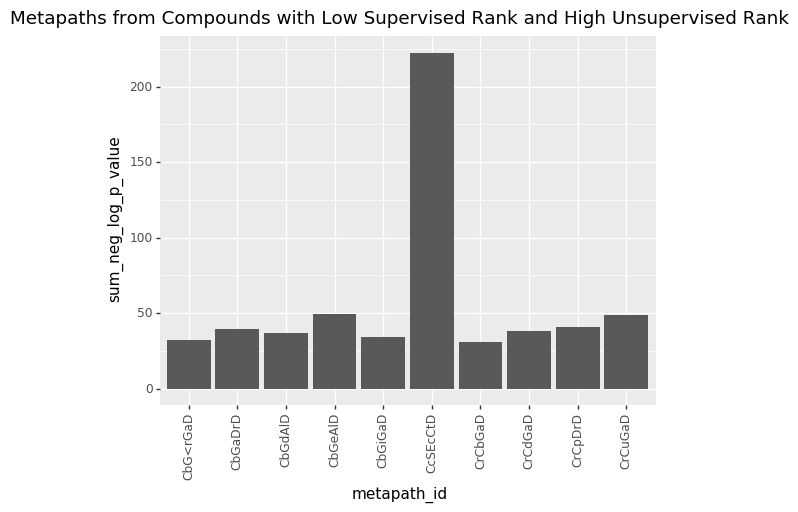

<ggplot: (8776446994766)>

In [10]:
(ggplot(low_supervised_rank_df, aes('metapath_id', 'sum_neg_log_p_value')) 
       + geom_bar(stat='identity') 
       + theme(axis_text_x = element_text(angle = 90, hjust = .5))
       + ggtitle('Metapaths from Compounds with Low Supervised Rank and High Unsupervised Rank') 
)

In [11]:
stacked_df = pandas.concat((high_supervised_rank_df, low_supervised_rank_df), keys=['high', 'low'])
stacked_df = stacked_df.reset_index(level=0)
stacked_df = stacked_df.rename(columns={'level_0': 'supervised_rank'})
stacked_df

,supervised_rank,metapath_id,sum_neg_log_p_value
0,high,CcSEcCtD,266.477444
1,high,CbGbCtD,96.622064
2,high,CrCbGaD,79.634679
3,high,CrCrCtD,57.709511
4,high,CbGaD,54.217686
5,high,CbGiGaD,39.699340
6,high,CrCtD,31.860002
7,high,CbGeAlD,27.614974
8,high,CbGdAlD,24.915543
9,high,CbGaDrD,23.826357


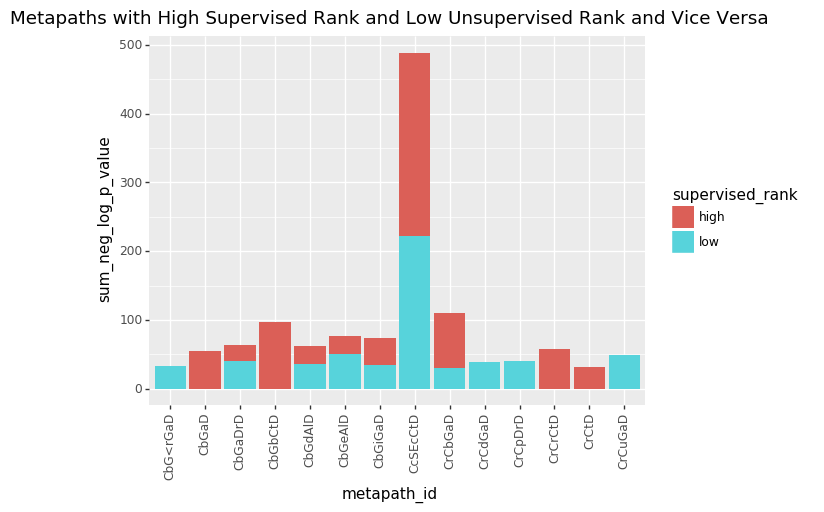

<ggplot: (-9223363260407739809)>

In [12]:
(ggplot(stacked_df, aes('metapath_id', 'sum_neg_log_p_value', fill='supervised_rank'))
+ geom_bar(stat='identity')
+ theme(axis_text_x = element_text(angle = 90, hjust = .5))
+ ggtitle('Metapaths with High Supervised Rank and Low Unsupervised Rank and Vice Versa') 
)

In [13]:
top_three_low_supervised_compounds =  combined_df.tail(500).sort_values(by='divergence', ascending=False)['source_name'].unique()[:3]
top_three_low_supervised_compounds

array(['Betamethasone', 'Acetyldigitoxin', 'Deslanoside'], dtype=object)

In [14]:
combined_df[combined_df['source_name'].isin(top_three_low_supervised_compounds)].drop(['compound_sum_neg_log_p_value', 
                                                                                       'compound_id', 'disease_id', 
                                                                                       'status', 'supervised_rank'], 
                                                                                       axis=1)

,path_count,p_value,metapath_id,source_name,target_name,neg_log_p_value,unsupervised_rank,divergence
1701,16,0.020005,CrCdGaD,Deslanoside,epilepsy syndrome,1.698855,276,1163
1696,15,0.074856,CbG<rGaD,Deslanoside,epilepsy syndrome,1.125775,276,1163
1697,2,0.000314,CbGaDrD,Deslanoside,epilepsy syndrome,3.502783,276,1163
1698,71,0.007870,CbGeAlD,Deslanoside,epilepsy syndrome,2.104035,276,1163
1699,25,0.004473,CbGuAlD,Deslanoside,epilepsy syndrome,2.349359,276,1163
1700,8,0.038391,CrCbGaD,Deslanoside,epilepsy syndrome,1.415766,276,1163
1702,46,0.005488,CrCuGaD,Deslanoside,epilepsy syndrome,2.260575,276,1163
73,16,0.020005,CrCdGaD,Acetyldigitoxin,epilepsy syndrome,1.698855,275,1165
72,8,0.038391,CrCbGaD,Acetyldigitoxin,epilepsy syndrome,1.415766,275,1165
71,25,0.004473,CbGuAlD,Acetyldigitoxin,epilepsy syndrome,2.349359,275,1165


In [15]:
url = 'https://github.com/dhimmel/hetionet/raw/76550e6c93fbe92124edc71725e8c7dd4ca8b1f5/hetnet/json/hetionet-v1.0.json.bz2'
metagraph = hetio.readwrite.read_metagraph(url)

In [16]:
all_metapath_results = []

damping_exponent = .5

for index, row in combined_df[combined_df['source_name'].isin(top_three_low_supervised_compounds)].iterrows():
    metapath_data = metagraph.metapath_from_abbrev(row['metapath_id'])
    
    query = hetio.neo4j.construct_pdp_query(metapath_data, path_style='list', property='name')
    
    driver = GraphDatabase.driver("bolt://neo4j.het.io")
    params = {
        'source': row['source_name'],
        'target': row['target_name'],
        'w': damping_exponent
    }
    with driver.session() as session:
        metapath_result = session.run(query, params)
        metapath_result = metapath_result.data()
        for i, entry in enumerate(metapath_result):
            metapath_result[i]['metapath_id'] = row['metapath_id']
            metapath_result[i]['source_name'] = row['source_name']
            metapath_result[i]['metapath_neg_log_p_value'] = row['neg_log_p_value']
        all_metapath_results.append(metapath_result)    

In [17]:
combined_results = []
for compound_metapath in all_metapath_results:
    for path in compound_metapath:
        combined_results.append(path)

In [18]:
results_df = pandas.DataFrame(combined_results)
results_df['path_importance'] = results_df['metapath_neg_log_p_value'] * results_df['percent_of_DWPC']

## Top Ten Paths
Now that we have our top compounds, we can pull out the top ten paths for each these compounds Information about the biology of the highest ranking of these paths can be found [here](https://github.com/greenelab/hetmech/pull/160#issuecomment-473359254)

In [23]:
top_paths_df = results_df.sort_values(by='path_importance', ascending=False).set_index('path')

In [24]:
top_paths_df[top_paths_df['source_name'] == 'Betamethasone'].head(10)

,PDP,metapath_id,metapath_neg_log_p_value,percent_of_DWPC,source_name,path_importance
path,,,,,,
"[Betamethasone, PGR, migraine, epilepsy syndrome]",0.002990,CbGaDrD,1.995252,100.000000,Betamethasone,199.525196
"[Betamethasone, Prednisone, migraine, epilepsy syndrome]",0.003098,CrCpDrD,1.512834,100.000000,Betamethasone,151.283351
"[Betamethasone, WARS, epilepsy syndrome]",0.002764,CdGaD,1.332989,29.674097,Betamethasone,39.555258
"[Betamethasone, systemic lupus erythematosus, Pregabalin, epilepsy syndrome]",0.003650,CtDpCtD,1.986496,19.371308,Betamethasone,38.481020
"[Betamethasone, multiple sclerosis, Diazepam, epilepsy syndrome]",0.002741,CtDpCtD,1.986496,14.548479,Betamethasone,28.900491
"[Betamethasone, multiple sclerosis, Oxcarbazepine, epilepsy syndrome]",0.002741,CtDpCtD,1.986496,14.548479,Betamethasone,28.900491
"[Betamethasone, multiple sclerosis, Pregabalin, epilepsy syndrome]",0.002238,CtDpCtD,1.986496,11.878783,Betamethasone,23.597152
"[Betamethasone, CAMSAP2, epilepsy syndrome]",0.001478,CdGaD,1.332989,15.861472,Betamethasone,21.143175
"[Betamethasone, multiple sclerosis, Carbamazepine, epilepsy syndrome]",0.001938,CtDpCtD,1.986496,10.287328,Betamethasone,20.435733


In [25]:
top_paths_df[top_paths_df['source_name'] == 'Acetyldigitoxin'].head(10)

,PDP,metapath_id,metapath_neg_log_p_value,percent_of_DWPC,source_name,path_importance
path,,,,,,
"[Acetyldigitoxin, ATP1A2, migraine, epilepsy syndrome]",0.015048,CbGaDrD,3.502783,50.000000,Acetyldigitoxin,175.139155
"[Acetyldigitoxin, ATP1A3, migraine, epilepsy syndrome]",0.015048,CbGaDrD,3.502783,50.000000,Acetyldigitoxin,175.139155
"[Acetyldigitoxin, Digitoxin, SLCO1A2, epilepsy syndrome]",0.000650,CrCbGaD,1.415766,24.631104,Acetyldigitoxin,34.871877
"[Acetyldigitoxin, Ouabain, SLCO1A2, epilepsy syndrome]",0.000573,CrCbGaD,1.415766,21.722592,Acetyldigitoxin,30.754105
"[Acetyldigitoxin, Digitoxin, CYP11A1, epilepsy syndrome]",0.000546,CrCbGaD,1.415766,20.705760,Acetyldigitoxin,29.314509
"[Acetyldigitoxin, Digitoxin, ATIC, epilepsy syndrome]",0.000280,CrCdGaD,1.698855,13.169655,Acetyldigitoxin,22.373336
"[Acetyldigitoxin, Digoxin, SLCO1A2, epilepsy syndrome]",0.000367,CrCbGaD,1.415766,13.893816,Acetyldigitoxin,19.670391
"[Acetyldigitoxin, ATP1B2, telencephalon, epilepsy syndrome]",0.000115,CbGuAlD,2.349359,8.100863,Acetyldigitoxin,19.031838
"[Acetyldigitoxin, ATP1A3, telencephalon, epilepsy syndrome]",0.000106,CbGuAlD,2.349359,7.499942,Acetyldigitoxin,17.620059


In [26]:
top_paths_df[top_paths_df['source_name'] == 'Deslanoside'].head(10)

,PDP,metapath_id,metapath_neg_log_p_value,percent_of_DWPC,source_name,path_importance
path,,,,,,
"[Deslanoside, ATP1A2, migraine, epilepsy syndrome]",0.015048,CbGaDrD,3.502783,50.000000,Deslanoside,175.139155
"[Deslanoside, ATP1A3, migraine, epilepsy syndrome]",0.015048,CbGaDrD,3.502783,50.000000,Deslanoside,175.139155
"[Deslanoside, Digitoxin, SLCO1A2, epilepsy syndrome]",0.000650,CrCbGaD,1.415766,24.631104,Deslanoside,34.871877
"[Deslanoside, Ouabain, SLCO1A2, epilepsy syndrome]",0.000573,CrCbGaD,1.415766,21.722592,Deslanoside,30.754105
"[Deslanoside, Digitoxin, CYP11A1, epilepsy syndrome]",0.000546,CrCbGaD,1.415766,20.705760,Deslanoside,29.314509
"[Deslanoside, Digitoxin, ATIC, epilepsy syndrome]",0.000280,CrCdGaD,1.698855,13.169655,Deslanoside,22.373336
"[Deslanoside, Digoxin, SLCO1A2, epilepsy syndrome]",0.000367,CrCbGaD,1.415766,13.893816,Deslanoside,19.670391
"[Deslanoside, ATP1B2, telencephalon, epilepsy syndrome]",0.000115,CbGuAlD,2.349359,8.100863,Deslanoside,19.031838
"[Deslanoside, ATP1A3, telencephalon, epilepsy syndrome]",0.000106,CbGuAlD,2.349359,7.499942,Deslanoside,17.620059
